In [ ]:
library(tidyverse)
library(repr)
install.packages("e1071") #SVM
library(e1071)
install.packages("naivebayes") #SVM
library(naivebayes)
install.packages("randomForest") #SVM
library(randomForest)
install.packages("caret") #SVM & Cross-validation (currently not working properly)
library(caret)
install.packages("kernlab") #SVM
library(kernlab)
install.packages("mlr") # For machine learning tasks and cross-validation
library(mlr)
install.packages("ranger") #for random forest
install.packages("parsnip") #for cross-validation (SVM)
library(parsnip)
install.packages("dplyr") #for finding velocity
library(dplyr)
# install.packages("tune")  # for Bayesian Optimization
# library(tune)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

naivebayes 0.9.7 loaded

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dpl

In [ ]:
# install.packages("xgboost") # for gradient boosting
# library(xgboost)

install.packages("tidymodels")
library(tidymodels)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘furrr’, ‘slider’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘infer’, ‘modeldata’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.6     ✔ workflows    1.1.3
✔ modeldata    1.3.0     ✔ workflowsets 1.0.1
✔ recipes      1.0.9     ✔ yardstick    1.3.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::alpha()          masks kernlab::alpha(), ggplot2::alpha()
✖ randomForest::combine()  masks dplyr::combine()
✖ kernlab::cross()         masks purrr::cross()
✖ scales::discard()        masks purrr::discard()
✖ dplyr::filter()          masks stats::filter()
✖ recipes::fixed()         masks stringr::fixed()


In [ ]:
set.seed(42)
pls_work <- read_csv("t-sne3_velocity.csv") |>
  mutate(pd = as_factor(pd), dominant = as_factor(dominant), used = as_factor(used))
# pls_work$domres <- ifelse(pls_work$dominant == pls_work$used, "dominant", "recessive")
pls_work <- pls_work |>
  mutate(domres = as_factor(domres))
# pls_work

Rows: 139 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): email, dominant, used
dbl (5): timestamp, tsne1, tsne2, tsne3, velocity
lgl (2): pd, domres

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# --- BELOW BEGINS PD ANALYSIS ---
pd_split <- initial_split(pls_work, prop = 0.60, strata = pd)
pd_train <- training(pd_split)
pd_test <- testing(pd_split)

pd_vfold <- vfold_cv(pd_train, v = 5, strata = pd)

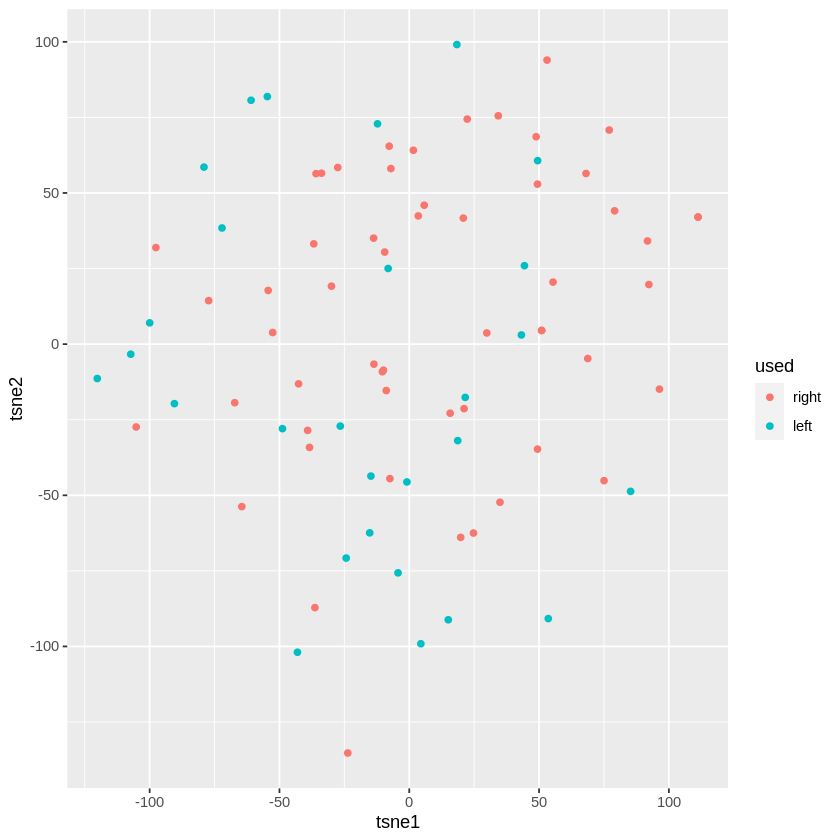

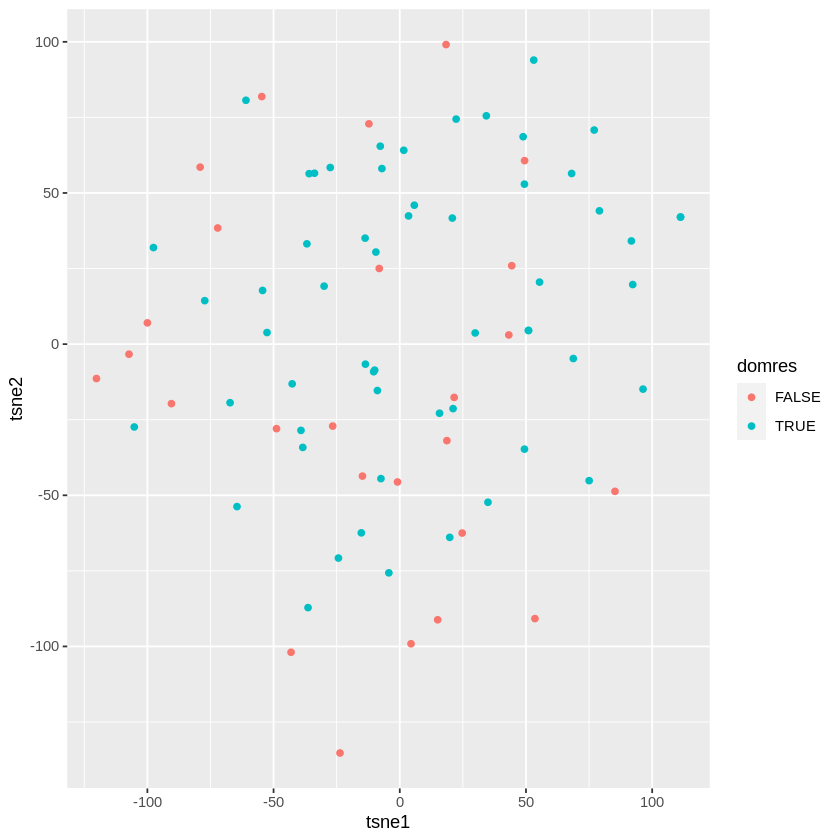

In [ ]:
ggplot(pd_train, aes(x = tsne1, y = tsne2, color = used)) +
    geom_point()
ggplot(pd_train, aes(x = tsne1, y = tsne2, color = domres)) +
    geom_point()

In [ ]:
install.packages("kknn")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘igraph’




In [ ]:
library(kknn)
pd_recipe <- recipe(pd ~ tsne1 + tsne2, data = pd_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

gridvals <- tibble(neighbors = seq(1, 20))

# to find optimal neighbors
# knn_workflow <- workflow() |>
#     add_recipe(pd_recipe) |>
#     add_model(knn_tune) |>
#     tune_grid(resamples = pd_vfold, grid = gridvals) |>
#     collect_metrics()
# knn_workflow

knn_workflow <- workflow() |>
    add_recipe(pd_recipe) |>
    add_model(knn_spec) |>
    fit(data = pd_train)
knn_workflow

ERROR: Error in library(kknn): there is no package called ‘kknn’


In [ ]:
# if using tune_grid
accuracies <- knn_workflow |>
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

In [ ]:
prediction <- predict(knn_workflow, pd_test) |>
    bind_cols(pd_test)
prediction
accuracy <- prediction |>
    metrics(truth = pd, estimate = .pred_class)
accuracy

pd_matrix <- prediction |>
  conf_mat(truth = pd, estimate = .pred_class)
pd_matrix

In [ ]:
# --- BELOW BEGINS LEFT/RIGHT ANALYSIS ---

set.seed(42)
lr_split <- initial_split(pls_work, prop = 0.60, strata = domres)
lr_train <- training(lr_split)
lr_test <- testing(lr_split)

ggplot(lr_train, aes(x = tsne1, y = tsne2, color = domres)) +
    geom_point()

lr_vfold <- vfold_cv(lr_train, v = 5, strata = domres)

lr_recipe <- recipe(domres ~ tsne1 + tsne2, data = lr_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_spec_lr <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
    set_engine("kknn") |>
    set_mode("classification")

gridvals <- tibble(neighbors = seq(1, 20))

# to find optimal neighbors
# knn_lr_workflow <- workflow() |>
#     add_recipe(lr_recipe) |>
#     add_model(knn_tune) |>
#     tune_grid(resamples = lr_vfold, grid = gridvals) |>
#     collect_metrics()
# knn_lr_workflow

knn_lr_workflow <- workflow() |>
    add_recipe(lr_recipe) |>
    add_model(knn_spec_lr) |>
    fit(data = lr_train)
knn_lr_workflow

In [ ]:
# if using tune_grid
accuracies_lr <- knn_lr_workflow |>
      filter(.metric == "accuracy")

accuracy_versus_k_lr <- ggplot(accuracies_lr, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k_lr

In [ ]:
prediction_lr <- predict(knn_lr_workflow, lr_test) |>
    bind_cols(lr_test)
prediction_lr
accuracy_lr <- prediction_lr |>
    metrics(truth = domres, estimate = .pred_class)
accuracy_lr

pd_matrix_lr <- prediction_lr |>
  conf_mat(truth = domres, estimate = .pred_class)
pd_matrix_lr

Rows: 139 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): email, dominant, used
dbl (5): timestamp, tsne1, tsne2, tsne3, velocity
lgl (2): pd, domres

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: [1m[33mError[39m in `check_installs()`:[22m
[33m![39m This engine requires some package installs: 'kknn'


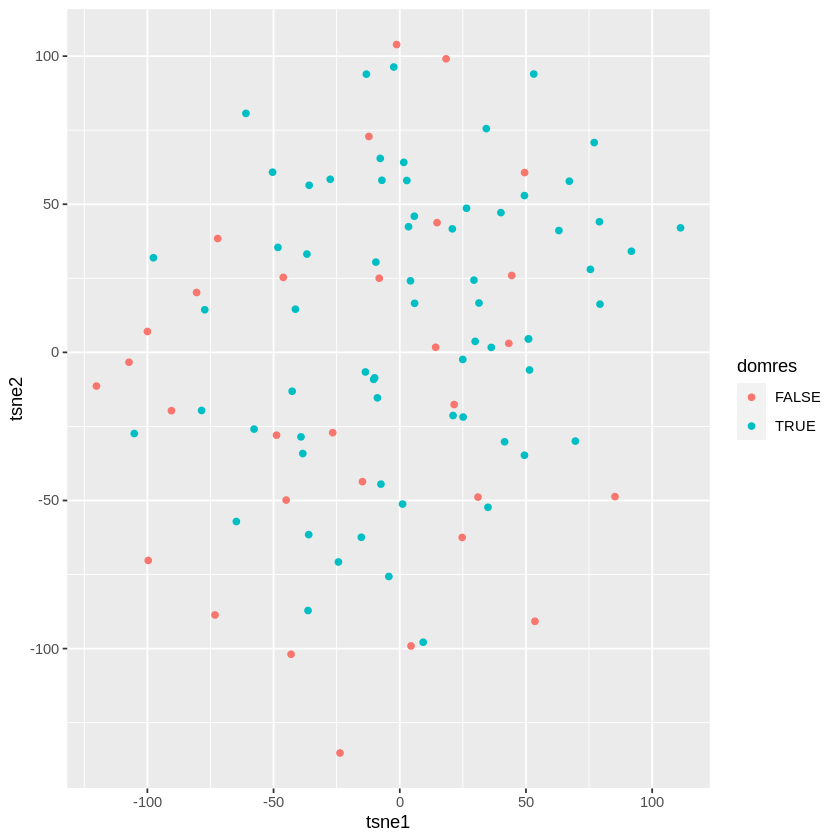

In [ ]:
# --- BELOW BEGINS LEFT/RIGHT ANALYSIS (rough draft) USING TSNE AND 3 DIMENSIONS---
# --- THIS CODE WILL OVERRIDE ALL OTHER VARIABLES. BE SURE TO ONLY RERUN THIS AND THE ABOVE TWO CODE BLOCKS FOR RESULTS.

set.seed(42)
pls_work <- read_csv("t-sne3_velocity.csv") |>
  mutate(pd = as_factor(pd), dominant = as_factor(dominant), used = as_factor(used))
# pls_work$domres <- ifelse(pls_work$dominant == pls_work$used, "dominant", "recessive")
pls_work <- pls_work |>
  mutate(domres = as_factor(domres))

lr_split <- initial_split(pls_work, prop = 0.70, strata = domres)
lr_train <- training(lr_split)
lr_test <- testing(lr_split)

ggplot(lr_train, aes(x = tsne1, y = tsne2, color = domres)) +
    geom_point()

lr_vfold <- vfold_cv(lr_train, v = 5, strata = domres)

lr_recipe <- recipe(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "epanechnikov", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_spec_lr <- nearest_neighbor(weight_func = "epanechnikov", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

gridvals <- tibble(neighbors = seq(1, 20))

# # # to find optimal neighbors
# knn_lr_workflow <- workflow() |>
#     add_recipe(lr_recipe) |>
#     add_model(knn_tune) |>
#     tune_grid(resamples = lr_vfold, grid = gridvals) |>
#     collect_metrics()
# knn_lr_workflow

knn_lr_workflow <- workflow() |>
    add_recipe(lr_recipe) |>
    add_model(knn_spec_lr) |>
    fit(data = lr_train)
knn_lr_workflow

#cross-validation (10 fold)
lr_recipe <- recipe(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_spec_lr <- nearest_neighbor(weight_func = "epanechnikov", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

gridvals <- tibble(neighbors = seq(1, 20))

lr_vfold <- vfold_cv(lr_train, v = 10, strata = domres)

knn_lr_workflow <- workflow() |>
    add_recipe(lr_recipe) |>
    add_model(knn_spec_lr)

# Perform cross-validation using tune() and fit_resamples()
knn_lr_results <- knn_lr_workflow |>
    tune_grid(resamples = lr_vfold, grid = gridvals) |>
    collect_metrics()

# Extract accuracy values
accuracy_values <- knn_lr_results %>%
    filter(.metric == "accuracy") %>%
    pull(mean)

# Print out accuracy values
print(accuracy_values)

In [ ]:
pls_work <- pls_work %>%
  mutate(dominant = as.factor(dominant),
         used = as.factor(used),
         pd = as.factor(pd),
         domres = as.factor(domres))

# Split the data into training and testing sets
lr_split <- initial_split(pls_work, prop = 0.70, strata = domres)
lr_train <- training(lr_split)
lr_test <- testing(lr_split)

# Create 10-fold cross-validation folds manually
lr_folds <- vfold_cv(lr_train, v = 10)

# Define recipe and model
lr_recipe <- recipe(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train) %>%
  step_center(all_predictors()) %>%
  step_scale(all_predictors())

knn_spec_lr <- nearest_neighbor(weight_func = "epanechnikov", neighbors = 9) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# Build the workflow
knn_lr_workflow <- workflow() %>%
  add_recipe(lr_recipe) %>%
  add_model(knn_spec_lr)

# Fit and evaluate the model using 10-fold cross-validation
knn_lr_results <- fit_resamples(knn_lr_workflow, lr_folds)

head(knn_lr_results)

In [ ]:
prediction_lr <- predict(knn_lr_workflow, lr_test) |>
    bind_cols(lr_test)
prediction_lr
accuracy_lr <- prediction_lr |>
    metrics(truth = domres, estimate = .pred_class)
accuracy_lr

pd_matrix_lr <- prediction_lr |>
  conf_mat(truth = domres, estimate = .pred_class)
pd_matrix_lr

In [ ]:
svm_model <- svm(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train, kernel = "radial", cost = 1)
svm_predictions <- predict(svm_model, newdata = lr_test)

confusion_matrix <- confusionMatrix(data = svm_predictions, reference = lr_test$domres)
accuracy <- confusion_matrix$overall["Accuracy"]
print(paste("Accuracy:", round(accuracy, 4)))

In [ ]:
# SVM model with radial basis function (RBF) kernel
svm_model_rbf <- svm(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train, kernel = "radial", cost = 1)
# confusion_rbf <- confusionMatrix(svm_predictions_rbf, lr_test$domres) #better/faster method

# SVM model with linear kernel
svm_model_linear <- svm(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train, kernel = "linear", cost = 1)

# SVM model with polynomial kernel
svm_model_poly <- svm(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train, kernel = "polynomial", degree = 3, cost = 1)

# Naive Bayes model
nb_model <- naiveBayes(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train)

# Random Forest model
rf_model <- randomForest(domres ~ tsne1 + tsne2 + tsne3 + velocity, data = lr_train, ntree = 10000)

# Predict with the models
svm_predictions_rbf <- predict(svm_model_rbf, newdata = lr_test)
svm_predictions_linear <- predict(svm_model_linear, newdata = lr_test)
svm_predictions_poly <- predict(svm_model_poly, newdata = lr_test)
nb_predictions <- predict(nb_model, newdata = lr_test)
rf_predictions <- predict(rf_model, newdata = lr_test)

# Evaluate model performance
confusion_matrix_rbf <- table(Reference = lr_test$domres, Predicted = svm_predictions_rbf)
accuracy_rbf <- sum(diag(confusion_matrix_rbf)) / sum(confusion_matrix_rbf)
print(paste("SVM RBF Accuracy:", round(accuracy_rbf, 3)))

confusion_matrix_linear <- table(Reference = lr_test$domres, Predicted = svm_predictions_linear)
accuracy_linear <- sum(diag(confusion_matrix_linear)) / sum(confusion_matrix_linear)
print(paste("SVM Linear Accuracy:", round(accuracy_linear, 3)))

confusion_matrix_poly <- table(Reference = lr_test$domres, Predicted = svm_predictions_poly)
accuracy_poly <- sum(diag(confusion_matrix_poly)) / sum(confusion_matrix_poly)
print(paste("SVM Polynomial Accuracy:", round(accuracy_poly, 3)))

confusion_matrix_nb <- table(Reference = lr_test$domres, Predicted = nb_predictions)
accuracy_nb <- sum(diag(confusion_matrix_nb)) / sum(confusion_matrix_nb)
print(paste("Naive Bayes Accuracy:", round(accuracy_nb, 4)))

confusion_matrix_rf <- table(Reference = lr_test$domres, Predicted = rf_predictions)
accuracy_rf <- sum(diag(confusion_matrix_rf)) / sum(confusion_matrix_rf)
print(paste("Random Forest Accuracy:", round(accuracy_rf, 4)))

confusion_matrix_nb

In [ ]:
#DIFFERENT METHOD FOR SVM (faster/less code)
# Define the models
svm_model_linear <- svm(domres ~ tsne1 + tsne2 + tsne3, data = lr_train, kernel = "linear", cost = 1)
svm_model_poly <- svm(domres ~ tsne1 + tsne2 + tsne3, data = lr_train, kernel = "polynomial", degree = 3, cost = 1)
nb_model <- naiveBayes(domres ~ tsne1 + tsne2 + tsne3, data = lr_train)
rf_model <- randomForest(domres ~ tsne1 + tsne2 + tsne3, data = lr_train, ntree = 10000)

# Predict with the models
svm_predictions_linear <- predict(svm_model_linear, newdata = lr_test)
svm_predictions_poly <- predict(svm_model_poly, newdata = lr_test)
nb_predictions <- predict(nb_model, newdata = lr_test)
rf_predictions <- predict(rf_model, newdata = lr_test)

# Create a list of models and predictions
models <- list(
  "SVM Linear" = svm_predictions_linear,
  "SVM Polynomial" = svm_predictions_poly,
  "Naive Bayes" = nb_predictions,
  "Random Forest" = rf_predictions
)

# Evaluate model performance
for (model_name in names(models)) {
  confusion_matrix <- table(Reference = lr_test$domres, Predicted = models[[model_name]])
  accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
  print(paste(model_name, "Accuracy:", round(accuracy, 3)))
}


ERROR: Error in eval(expr, p): object 'lr_train' not found


In [ ]:
#Half-hearted PSA attempt that failed
lr_recipe <- recipe(domres ~ ., data = lr_train) |>
  select(where(is.numeric)) |>  # Select only numeric columns
  step_center(all_predictors()) |>
  step_scale(all_predictors()) |>
  step_pca(all_predictors(), num_comp = 2)

knn_spec_lr <- nearest_neighbor(weight_func = "epanechnikov", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_lr_workflow <- workflow() |>
  add_recipe(lr_recipe) |>
  add_model(knn_spec_lr) |>
  fit(data = lr_train)

In [ ]:
library(readr)
library(tidyr)
library(dplyr)
library(parsnip)
library(workflows)

In [ ]:
# gradient boosting (aattempt) failed :(
#Load your data
set.seed(42)
pls_work <- read_csv("t-sne3.csv") |>
  mutate(pd = as_factor(pd), dominant = as_factor(dominant), used = as_factor(used))
pls_work$domres <- ifelse(pls_work$dominant == pls_work$used, "dominant", "recessive")
pls_work <- pls_work |>
  mutate(domres = as_factor(domres))

# Split the data into training and testing sets
lr_split <- initial_split(pls_work, prop = 0.70, strata = domres)
lr_train <- lr_split$train  # Training data
lr_test <- lr_split$test    # Testing data

# Define a recipe for data preprocessing
lr_recipe <- recipe(pd ~ tsne1 + tsne2 + tsne3 + dominant + used, data = lr_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

# Define the XGBoost model and tuning grid
xgb_spec_lr <- boost_tree(
  mode = "classification",
  trees = tune(),  # Tune the number of trees
  min_n = tune()   # Tune the minimum number of observations in terminal nodes
) %>%
  set_engine("xgboost")

# Define the grid for tuning
gridvals <- expand.grid(trees = c(50, 100, 150), min_n = c(1, 5, 10))

# Create a workflow for XGBoost with tuning
xgb_lr_workflow <- workflow() %>%
  add_recipe(lr_recipe) %>%
  add_model(xgb_spec_lr)

# Fit the XGBoost model separately
xgb_lr_model <- xgb_lr_workflow %>%
  fit(data = lr_train)

# Make predictions on the test data
prediction_xgb <- predict(xgb_lr_model, lr_test) %>%
  bind_cols(lr_test)

# Calculate accuracy
accuracy_xgb <- prediction_xgb %>%
  metrics(truth = domres, estimate = .pred_class)

# Confusion matrix
pd_matrix_xgb <- prediction_xgb %>%
  conf_mat(truth = domres, estimate = .pred_class)

# Print the results
print(accuracy_xgb)
print(pd_matrix_xgb)

In [ ]:
#The hunt for velocity (checking one csv file at a time)

find_velocity <- read.csv("1665514876842.csv")

# Extract relevant columns (x, y, and timestamp)
coordinates_x <- find_velocity$x
coordinates_y <- find_velocity$y
coordinates_timestamp <- find_velocity$timestamp

# Create a list of coordinates
coordinates <- list(x = coordinates_x, y = coordinates_y, timestamp = coordinates_timestamp)

# Calculate the Euclidean distance between two points
calculate_distance <- function(x1, y1, x2, y2) {
  sqrt((x2 - x1)^2 + (y2 - y1)^2)
}

# Calculate mean velocity
calculate_mean_velocity <- function(coordinates) {
  velocities <- numeric(0)

  for (i in 1:(length(coordinates$x) - 1)) {
    x1 <- coordinates$x[i]
    y1 <- coordinates$y[i]
    x2 <- coordinates$x[i + 1]
    y2 <- coordinates$y[i + 1]
    timestamp1 <- coordinates$timestamp[i]
    timestamp2 <- coordinates$timestamp[i + 1]

    distance <- calculate_distance(x1, y1, x2, y2)
    time_difference <- (timestamp2 - timestamp1) / 1000  # Convert timestamp to seconds

    if (time_difference > 0) {  # Check if time_difference is greater than zero
      velocity <- distance / time_difference
    } else {
      velocity <- 0  # Set velocity to zero when time_difference is zero
    }

    velocities <- c(velocities, velocity)

    cat("Velocity between points", i, "and", i + 1, ":", velocity, "units/second\n")
  }

  mean_velocity <- mean(velocities, na.rm = TRUE)
  return(mean_velocity)
}

# Calculate and print the mean velocity
mean_velocity <- calculate_mean_velocity(coordinates)
cat("Mean Velocity:", mean_velocity, "units/second\n")


In [ ]:
install.packages("readr")
library(readr)

In [ ]:
#Calculate mean velocity for a whole folder of files and distinguish dom/nondom

# Function to calculate mean velocity and hand equality for a single CSV file
calculate_mean_velocity <- function(file_path) {
  # Check if the file is empty (has zero size)
  file_info <- file.info(file_path)
  if (file_info$size == 0) {
    cat("File is empty, skipping:", file_path, "\n")
    return(list(mean_velocity = NA, hand_equality = NA))
  }

  find_velocity <- read_csv(file_path)

  # Check if the CSV file has the required columns
  required_columns <- c("x", "y", "timestamp", "drawnHand", "dominantHand")
  if (!all(required_columns %in% colnames(find_velocity))) {
    cat("Error: The CSV file", file_path, "does not have the required columns (x, y, timestamp, drawnHand, dominantHand).\n")
    return(list(mean_velocity = NA, hand_equality = NA))
  }

  # Extract relevant columns (x, y, timestamp, drawnHand, and dominantHand)
  coordinates <- select(find_velocity, x, y, timestamp, drawnHand, dominantHand)

  # Calculate the Euclidean distance between two points
  calculate_distance <- function(x1, y1, x2, y2) {
    sqrt((x2 - x1)^2 + (y2 - y1)^2)
  }

  # Calculate mean velocity and hand equality
  velocities <- numeric(0)
  hand_equality <- logical(0)

  for (i in 1:(length(coordinates$x) - 1)) {
    x1 <- coordinates$x[i]
    y1 <- coordinates$y[i]
    x2 <- coordinates$x[i + 1]
    y2 <- coordinates$y[i + 1]
    timestamp1 <- coordinates$timestamp[i]
    timestamp2 <- coordinates$timestamp[i + 1]
    drawnHand1 <- coordinates$drawnHand[i]
    dominantHand1 <- coordinates$dominantHand[i]
    drawnHand2 <- coordinates$drawnHand[i + 1]
    dominantHand2 <- coordinates$dominantHand[i + 1]

    distance <- calculate_distance(x1, y1, x2, y2)
    time_difference <- (timestamp2 - timestamp1) / 1000  # Convert timestamp to seconds

    if (time_difference > 0) {  # Check if time_difference is greater than zero
      velocity <- distance / time_difference
    } else {
      velocity <- 0  # Set velocity to zero when time_difference is zero
    }

    velocities <- c(velocities, velocity)
    hand_equality <- c(hand_equality, drawnHand1 == dominantHand1)
  }

  mean_velocity <- mean(velocities, na.rm = TRUE)
  hand_equality_result <- all(hand_equality)

  return(list(mean_velocity = mean_velocity, hand_equality = hand_equality_result))
}

# Specify the folder containing CSV files
folder_path <- "/content/data_csv"

# List all CSV files in the folder
csv_files <- list.files(path = folder_path, pattern = ".csv", full.names = TRUE)

# Create a list to store results for each file
results_list <- list()

# Calculate and print mean velocity and hand equality for each CSV file
for (file in csv_files) {
  cat("Processing file:", file, "\n")
  results <- calculate_mean_velocity(file)
  results_list[[file]] <- results

  if (!is.na(results$mean_velocity)) {
    cat("Mean Velocity:", results$mean_velocity, "units/second\n")
    cat("Hand Equality:", results$hand_equality, "\n")
  }
}

#putting all of this info into csv files

# Create a data frame to store the results
result_df <- data.frame(
  file_name = character(0),
  dominant = logical(0),
  mean_velocity = numeric(0)
)

# Calculate and save mean velocity and hand equality for each CSV file
for (file in csv_files) {
  cat("Processing file:", file, "\n")
  results <- calculate_mean_velocity(file)

  # Check if mean_velocity is not NA before saving the result
  if (!is.na(results$mean_velocity)) {
    cat("Mean Velocity:", results$mean_velocity, "units/second\n")
    cat("Hand Equality:", results$hand_equality, "\n")

    # Add the result to the data frame
    result_df <- rbind(result_df, data.frame(
      file_name = file,
      dominant = results$hand_equality,
      mean_velocity = results$mean_velocity
    ))
  }
}

# Save the result data frame as a CSV file
result_csv_file <- "/content/mean_velocity_csv/mean_velocity.csv"  # Specify the desired output CSV file path
write.csv(result_df, file = result_csv_file, row.names = FALSE)

In [ ]:
# calculate velocity and distinguish dom/nondom and calculate overall mean of dom/nondom
library(readr)

# Function to calculate mean velocity for a single CSV file
calculate_mean_velocity <- function(file_path) {
  # Check if the file is empty (has zero size)
  file_info <- file.info(file_path)
  if (file_info$size == 0) {
    cat("File is empty, skipping:", file_path, "\n")
    return(list(mean_velocity = NA, hand_equality = NA))
  }

  find_velocity <- read_csv(file_path)

  # Check if the CSV file has the required columns
  required_columns <- c("x", "y", "timestamp", "drawnHand", "dominantHand")
  if (!all(required_columns %in% colnames(find_velocity))) {
    cat("Error: The CSV file", file_path, "does not have the required columns (x, y, timestamp, drawnHand, dominantHand).\n")
    return(list(mean_velocity = NA, hand_equality = NA))
  }

  # Extract relevant columns (x, y, timestamp, drawnHand, and dominantHand)
  coordinates <- select(find_velocity, x, y, timestamp, drawnHand, dominantHand)

  # Calculate the Euclidean distance between two points
  calculate_distance <- function(x1, y1, x2, y2) {
    sqrt((x2 - x1)^2 + (y2 - y1)^2)
  }

  # Initialize variables
  velocities <- numeric(0)
  hand_equality <- logical(0)
  velocities_not_equal <- numeric(0)
  velocities_equal <- numeric(0)  # Store velocities when dominantHand equals drawnHand

  for (i in 1:(length(coordinates$x) - 1)) {
    x1 <- coordinates$x[i]
    y1 <- coordinates$y[i]
    x2 <- coordinates$x[i + 1]
    y2 <- coordinates$y[i + 1]
    timestamp1 <- coordinates$timestamp[i]
    timestamp2 <- coordinates$timestamp[i + 1]
    drawnHand1 <- coordinates$drawnHand[i]
    dominantHand1 <- coordinates$dominantHand[i]
    drawnHand2 <- coordinates$drawnHand[i + 1]
    dominantHand2 <- coordinates$dominantHand[i + 1]

    distance <- calculate_distance(x1, y1, x2, y2)
    time_difference <- (timestamp2 - timestamp1) / 1000  # Convert timestamp to seconds

    if (time_difference > 0) {  # Check if time_difference is greater than zero
      velocity <- distance / time_difference
      velocities <- c(velocities, velocity)
      hand_equality <- c(hand_equality, drawnHand1 == dominantHand1)

      # Check if dominantHand is not equal to drawnHand
      if (drawnHand1 != dominantHand1 || drawnHand2 != dominantHand2) {
        velocities_not_equal <- c(velocities_not_equal, velocity)
      } else {
        velocities_equal <- c(velocities_equal, velocity)  # Store velocities when equal
      }
    }
  }

  mean_velocity <- mean(velocities, na.rm = TRUE)
  mean_velocity_not_equal <- mean(velocities_not_equal, na.rm = TRUE)
  mean_velocity_equal <- mean(velocities_equal, na.rm = TRUE)  # Calculate mean for equal hands
  mean_hand_equality <- mean(hand_equality, na.rm = TRUE)

  return(list(
    mean_velocity = mean_velocity,
    mean_velocity_not_equal = mean_velocity_not_equal,
    mean_velocity_equal = mean_velocity_equal,  # Include mean for equal hands
    mean_hand_equality = mean_hand_equality
  ))
}

# Specify the folder containing CSV files
folder_path <- "/content/data_csv"

# List all CSV files in the folder
csv_files <- list.files(path = folder_path, pattern = ".csv", full.names = TRUE)

# Initialize variables to store means
mean_velocity_list <- numeric(0)
mean_velocity_not_equal_list <- numeric(0)
mean_velocity_equal_list <- numeric(0)  # Initialize list for equal hands
mean_hand_equality_list <- numeric(0)

# Calculate and print mean velocity for each CSV file
for (file in csv_files) {
  cat("Processing file:", file, "\n")
  results <- calculate_mean_velocity(file)

  if (!is.na(results$mean_velocity)) {
    cat("Mean Velocity:", results$mean_velocity, "units/second\n")
    cat("Mean Velocity (DrawnHand != DominantHand):", results$mean_velocity_not_equal, "units/second\n")
    cat("Mean Velocity (DrawnHand == DominantHand):", results$mean_velocity_equal, "units/second\n")  # Print mean for equal hands
    cat("Mean Hand Equality:", results$mean_hand_equality, "\n")

    # Store means in lists
    mean_velocity_list <- c(mean_velocity_list, results$mean_velocity)
    mean_velocity_not_equal_list <- c(mean_velocity_not_equal_list, results$mean_velocity_not_equal)
    mean_velocity_equal_list <- c(mean_velocity_equal_list, results$mean_velocity_equal)  # Store mean for equal hands
    mean_hand_equality_list <- c(mean_hand_equality_list, results$mean_hand_equality)
  }
}

# Calculate and print overall means
overall_mean_velocity <- mean(mean_velocity_list, na.rm = TRUE)
overall_mean_velocity_not_equal <- mean(mean_velocity_not_equal_list, na.rm = TRUE)
overall_mean_velocity_equal <- mean(mean_velocity_equal_list, na.rm = TRUE)  # Calculate overall mean for equal hands
overall_mean_hand_equality <- mean(mean_hand_equality_list, na.rm = TRUE)

cat("Overall Mean Velocity:", overall_mean_velocity, "units/second\n")
cat("Overall Mean Velocity (DrawnHand != DominantHand):", overall_mean_velocity_not_equal, "units/second\n")
cat("Overall Mean Velocity (DrawnHand == DominantHand):", overall_mean_velocity_equal, "units/second\n")  # Print overall mean for equal hands
cat("Overall Mean Hand Equality:", overall_mean_hand_equality, "\n")


In [ ]:
data <- read.csv('mean_velocity.csv')
data$dominant <- as.numeric(data$dominant)

X <- data$dominant
y <- data$mean_velocity
set.seed(42)  # For reproducibility
train_indices <- sample(1:nrow(data), 0.8 * nrow(data))
train_data <- data[train_indices, ]
test_data <- data[-train_indices, ]

model <- lm(mean_velocity ~ dominant, data = train_data)
summary(model)  # Optional: View model summary

y_pred <- predict(model, newdata = test_data)
mse <- mean((y_pred - test_data$mean_velocity)^2)
r_squared <- 1 - (mse / var(test_data$mean_velocity))

cat("Mean Squared Error:", mse, "\n")
cat("R-squared:", r_squared, "\n")

new_data <- data.frame(dominant = c(1, 0, 1))  # Example new data
predictions <- predict(model, newdata = new_data)

In [ ]:
library(kknn)

In [ ]:
#attempt to use randomforest to train with velocities (failed)

library(caret)
library(randomForest)

data <- read.csv('mean_velocity.csv')
data$dominant <- as.numeric(data$dominant)

X <- data$dominant
y <- data$mean_velocity

# Split Data into Training and Testing Sets
set.seed(42)  # For reproducibility
train_indices <- sample(1:nrow(data), 0.8 * nrow(data))
train_data <- data[train_indices, ]
test_data <- data[-train_indices, ]

# Create and train the Random Forest regression model
rf_model <- randomForest(mean_velocity ~ dominant, data = train_data, ntree = 100)

# Predict mean_velocity using the trained Random Forest model
rf_predictions <- predict(rf_model, test_data)

# Calculate Mean Squared Error (MSE) and R-squared for Random Forest
mse_rf <- mean((rf_predictions - test_data$mean_velocity)^2)
r_squared_rf <- 1 - (mse_rf / var(test_data$mean_velocity))

cat("Random Forest Mean Squared Error:", mse_rf, "\n")
cat("Random Forest R-squared:", r_squared_rf, "\n")